In [110]:
# libraries
from operator import itemgetter
from IPython.display import display_html
from math import sqrt

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import folium
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [111]:
#network
G = nx.read_graphml("london.graph")

print(G)
list(G.nodes(data=True))[0]


Graph with 401 nodes and 467 edges


('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [112]:
#conver to tuple
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])
    
#check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

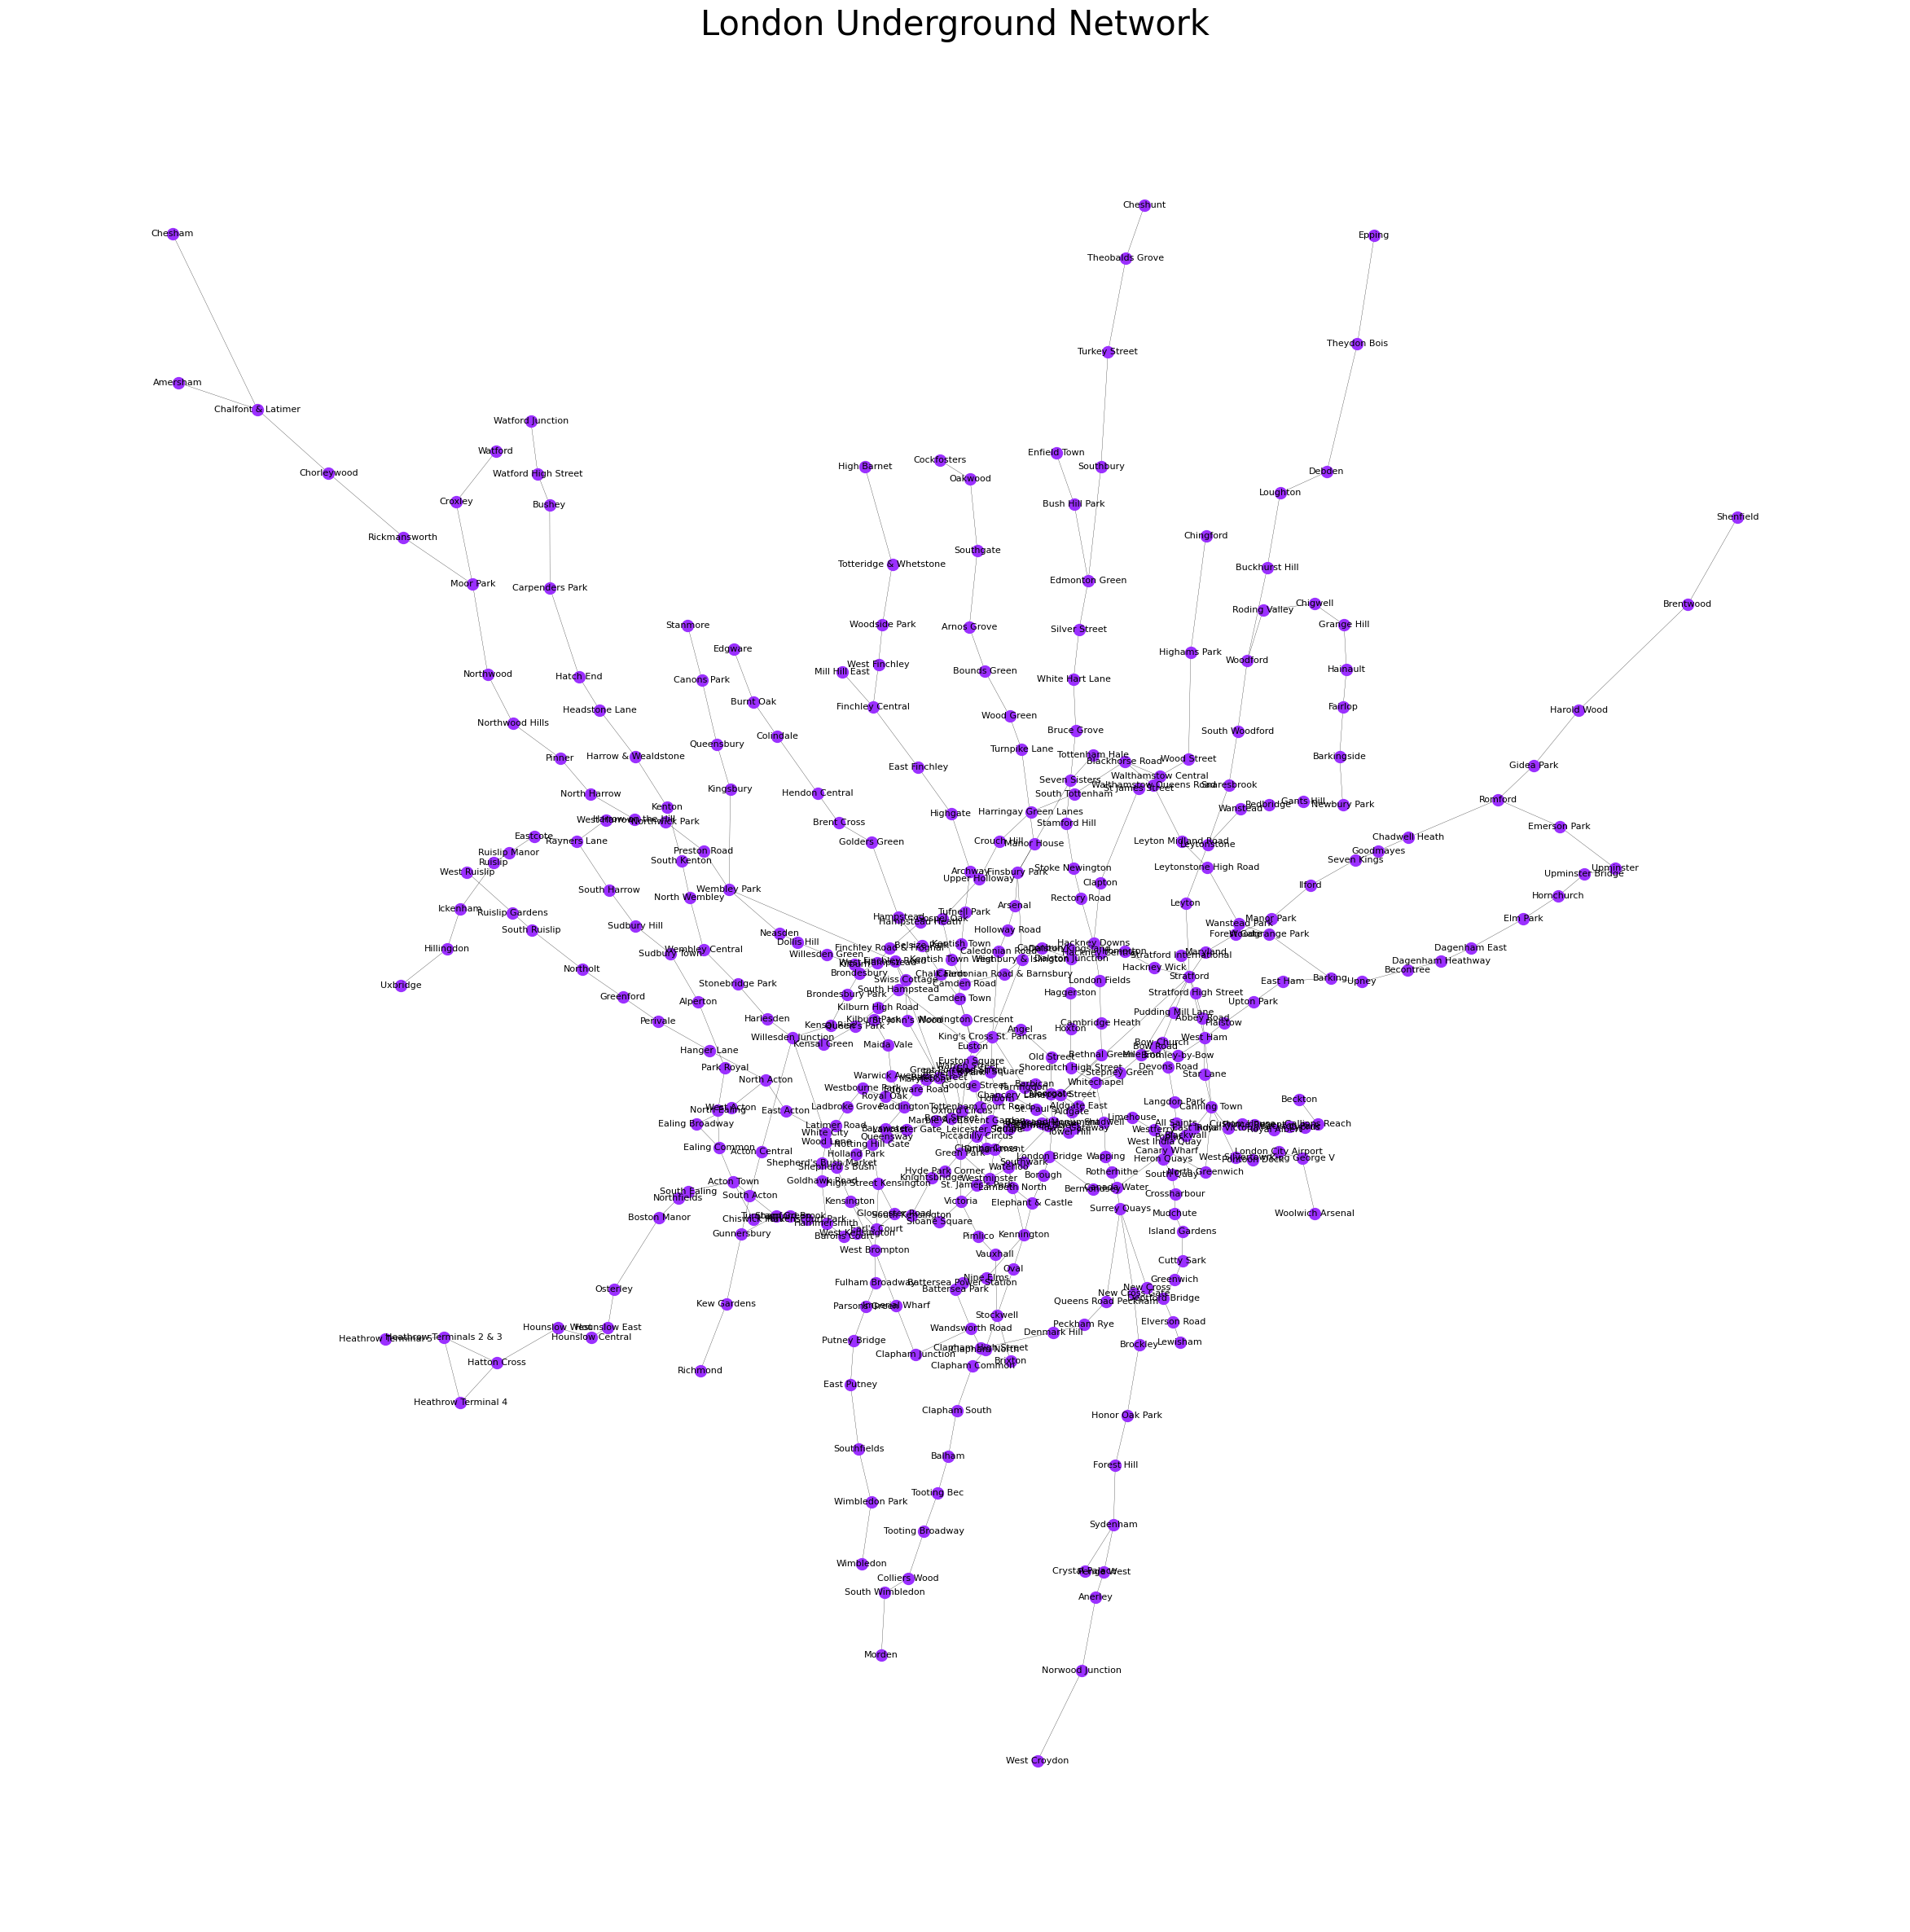

In [113]:
#plot the tube network then
fig, ax = plt.subplots(figsize=(30, 30))
pos = nx.get_node_attributes(G, "coords")
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="#9B30FF")
nx.draw_networkx_edges(G, pos, arrows=False, width=0.2)


nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")


plt.title("London Underground Network", fontsize=30)
plt.axis("off")
plt.show()

# Part 1: London’s underground resilience
## I. Topological network
### I.1. Centrality measures:
### 1. Degree Centrality
Definition: Degree Centrality measures how many direct connections (or edges) a node has to other nodes. In a subway network, a station with high Degree Centrality is directly connected to many other stations.
Formula ：$$C_{D}(v) = \frac{deg(v)}{n-1} $$ where 
deg(v) is the degree of node v (i.e., the number of direct connections), and N is the total number of nodes in the network.  
Application in the Underground:
In the London Underground, a station with high Degree Centrality is a hub that connects multiple lines or stations. Removing such a station could directly impact many routes and passengers' commutes.

### 2. Betweenness Centrality 
Definition:
Betweenness Centrality measures the frequency with which a node appears on the shortest paths between other nodes. A high Betweenness Centrality indicates that the node is a critical intermediary along these paths.
Formula:
\begin{equation}x_{i}=\sum_{st} \frac {n^{i}_{st}}{g_{st}}\end{equation}

\begin{equation}
n^{i}_{st}=\begin{cases}
1, & \text{if vertex $i$ lies on the geodesic path from $s$ to $t$}.\\
0, & \text{otherwise}.
  \end{cases}
\end{equation}
the number of geodesics from $s$ to $t$, $g_{st}$:

Application in the Underground:
Stations with high Betweenness Centrality are pivotal in connecting different areas or lines of the London Underground. Their removal could significantly decrease network efficiency, forcing passengers to take longer, less direct routes.

### 3 Closeness Centrality
Definition:
Closeness Centrality measures how quickly a node can reach all other nodes in the network. A node with high Closeness Centrality has a shorter average distance to all other nodes.

Formula:
\begin{equation} C_{i}= \frac{1}{l_{i}} = \frac{n}{\sum_{j} d_{ij}}\end{equation} 
of node $i$:

where $d_{ij}$ is the geodesic distance (shortest path) between node $i$ and $j$. The mean geodesic distance of node $i$ to all other nodes is given by:

    
\begin{equation} l_{i}=\frac{1}{n} \sum_{j} d_{ij}\end{equation}

Application in the Underground:
A station with high Closeness Centrality is effectively in the 'center' of the Underground network, allowing for quick distribution and redistribution of passenger flow across the network. Such stations are vital for maintaining the efficiency of the entire network.

In [114]:
#degree centrality
deg= nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg),'degree')
bet= nx.betweenness_centrality(G,normalized=False)
clos= nx.closeness_centrality(G)
nx.set_node_attributes(G,dict(bet),'betweenness')
nx.set_node_attributes(G,dict(clos),'closeness')


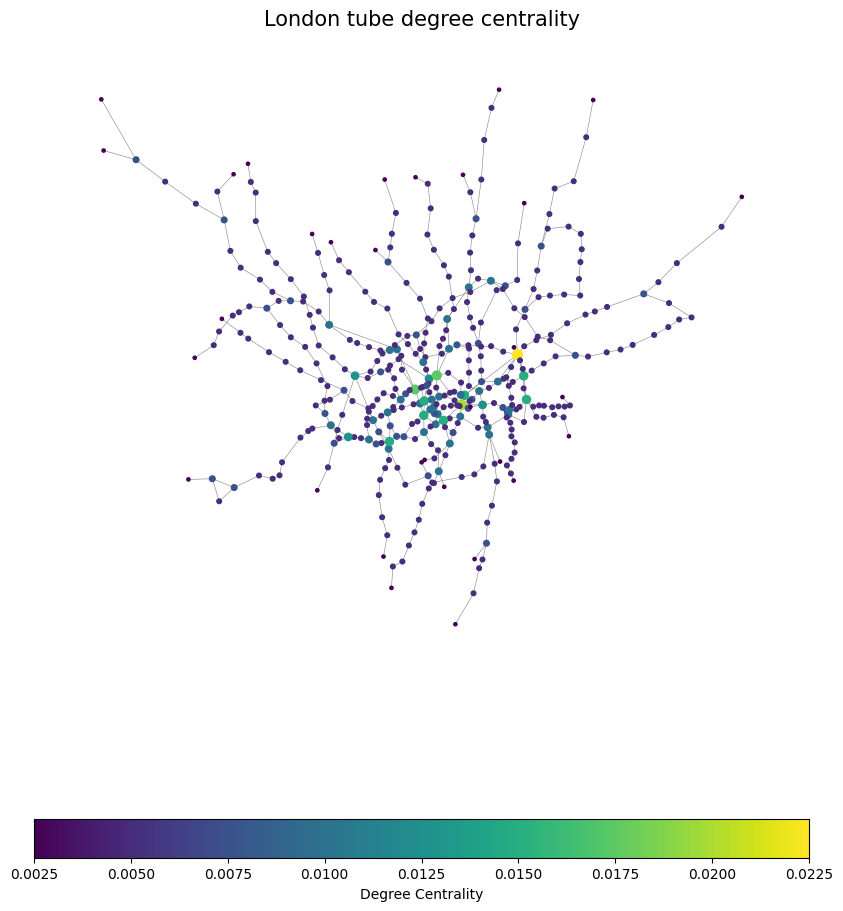

In [115]:
#plot of degree measure and top 10 ranked node

deg_color=[(node['degree']) for i, node in G.nodes(data=True)]
deg_size=[(float(node['degree'])/max(deg_color))*50 for i, node in G.nodes(data=True)]
fig, ax = plt.subplots(figsize=(10,12))
nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)
plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=1)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.show()

In [116]:
# top 10 of degree measuere
df_degree = pd.DataFrame(index=G.nodes())
df_degree["degree"] = pd.Series(nx.degree_centrality(G))  # Degree centrality computation
top_degree = df_degree.sort_values(["degree"], ascending=False).head(10)
top_degree


,degree
Stratford,0.0225
Bank and Monument,0.0200
King's Cross St. Pancras,0.0175
Baker Street,0.0175
Earl's Court,0.0150
Oxford Circus,0.0150
Liverpool Street,0.0150
Waterloo,0.0150
Green Park,0.0150
Canning Town,0.0150


In [117]:
df_closeness = pd.DataFrame(index=G.nodes())
df_closeness["closeness"] = pd.Series(nx.closeness_centrality(G))  # Closeness centrality computation
top_closeness = df_closeness.sort_values(["closeness"], ascending=False).head(10)
top_closeness

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [118]:
df_betweenness = pd.DataFrame(index=G.nodes())
df_betweenness["betweenness"] = pd.Series(nx.betweenness_centrality(G, normalized=True))  # Betweenness centrality computation
top_betweenness = df_betweenness.sort_values(["betweenness"], ascending=False).head(10)
top_betweenness

,betweenness
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


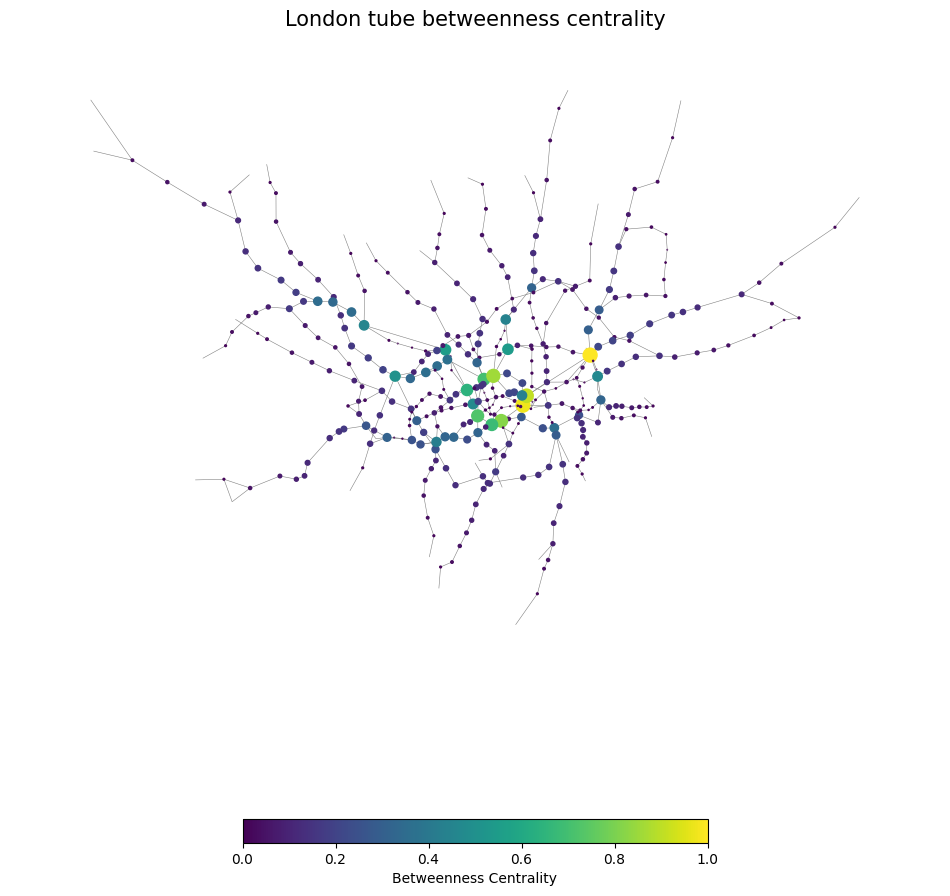

In [119]:
#top 10 node of betweenness measure
betweenness_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_color=[(i[1]['betweenness']/max(betweenness_values)) for i in G.nodes(data=True)]
bet_size=[(i[1]['betweenness']/max(betweenness_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_color,
        node_size= bet_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()


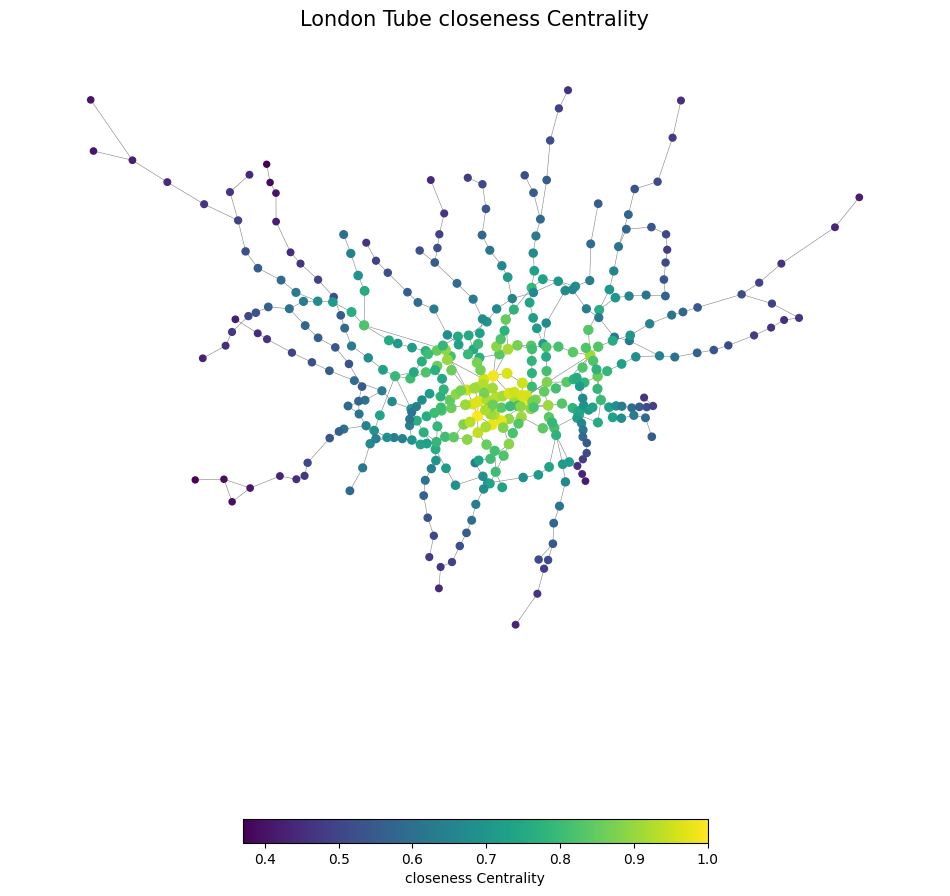

In [120]:
#plot for closeness measure
closeness_values=[(i[1]['closeness']) for i in G.nodes(data=True)]

bet_color=[(i[1]['closeness']/max(closeness_values)) for i in G.nodes(data=True)]
bet_size=[(i[1]['closeness']/max(closeness_values))*50 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_color,
        node_size= bet_size)

plt.colorbar(nod,label="closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube closeness Centrality",fontsize=15)
plt.show()

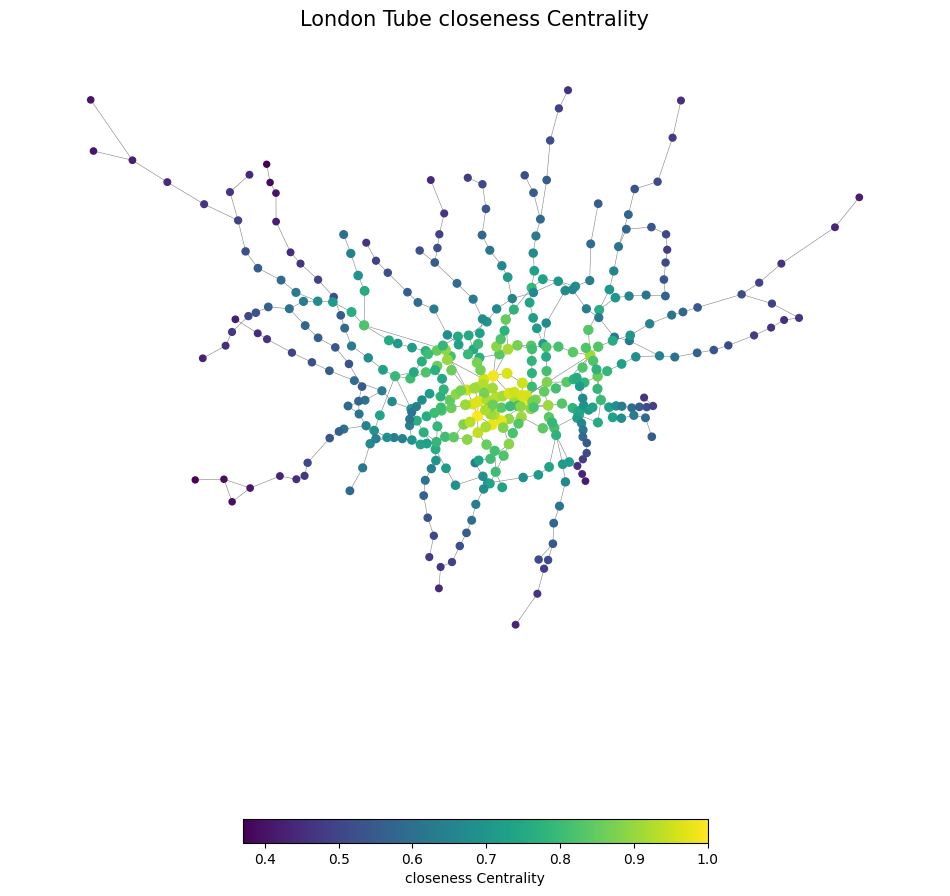

In [121]:
closeness_values=[(i[1]['closeness']) for i in G.nodes(data=True)]

bet_color=[(i[1]['closeness']/max(closeness_values)) for i in G.nodes(data=True)]
bet_size=[(i[1]['closeness']/max(closeness_values))*50 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_color,
        node_size= bet_size)

plt.colorbar(nod,label="closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Tube closeness Centrality",fontsize=15)
plt.show()

## 1.2 Impact measures
Resilienc or  the impact of the node removal on the network can be measured by 1Average clustering coefficient
2.Average shortest Path Length

### 1Average clustering coefficient
Average clustering coefficient also known as C   is the probability that two neighbors of a randomly selected node link
to each other. 
Formula, C=$1/N \sum_{i}^{n} C_{i}$
where$$ C_i = \frac{2L_i}{k_i(k_i-1)} $$

where $ L_i $ represents the number of links between the  $ k_i $ neighbours of node $i$.

a high average clustering coefficient would suggest that if two stations are both directly connected to a third station, there is a high probability they are also directly connected to each other. This can indicate a tightly-knit network where routes are redundant and can potentially offer alternative paths in case some stations or connections are unavailable. When evaluating resilience, a decrease in this measure after removing stations could indicate a loss of redundancy and connectivity within the network, making it more vulnerable to further disruptions. 

This measure can be use in the social network.A higher coefficient indicates more frequent interaction between users and a tighter group or community structure. This pattern of tight connections usually means that the network is somewhat resistant to the loss of nodes or connections. For example, if a user disappears from the network (possibly deleting their account), their friends may still be in touch with each other through other mutual friends.

### 2.global_efficiency
  It is defined as the average inverse shortest path length in the network and provides a measure of the average efficiency of information or transport flow across the network. Global efficiency measures how well information or transportation flows across the network despite the presence of disruptions.In London underground, Global efficiency can help identify which stations are critical for maintaining efficient transport across the entire network. By removing a station and observing the change in global efficiency, you can infer the station's importance. In social network,By analyzing the changes in the overall efficiency of the network after the removal of specific individuals, it is possible to identify those key players who have a greater impact on the structure and function of the network. These key people often act as "Bridges" or "contacts," connecting groups or individuals who would not otherwise have direct contact



## 1.3Node removal:

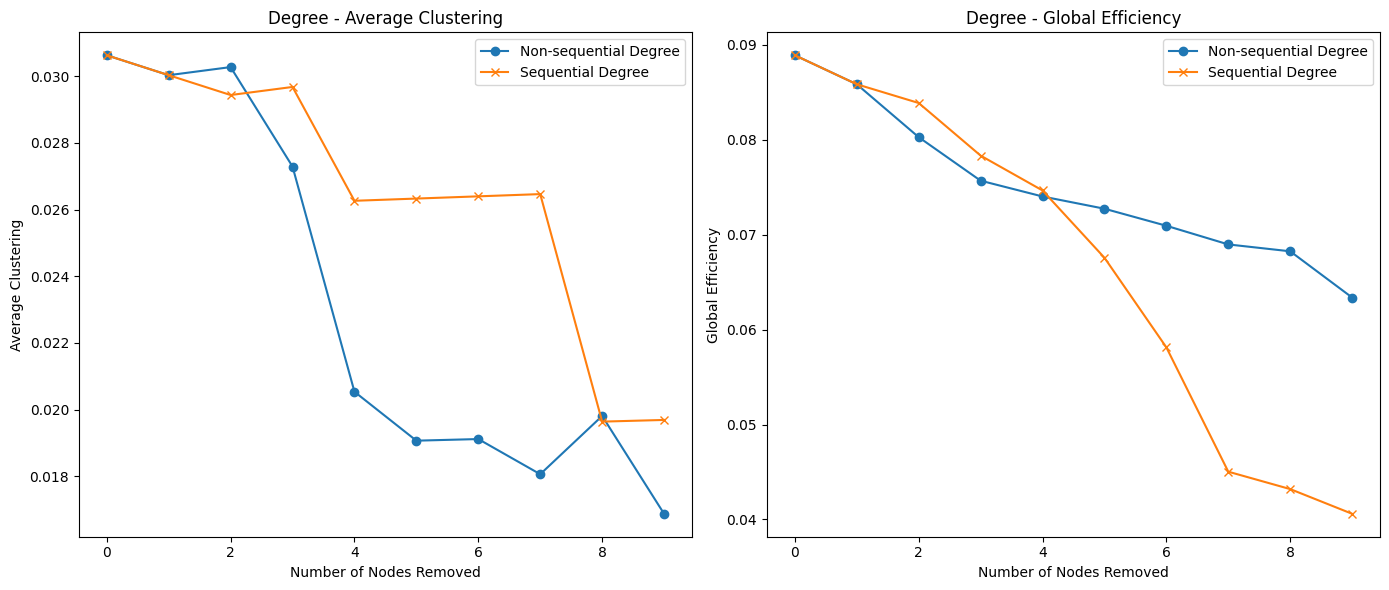

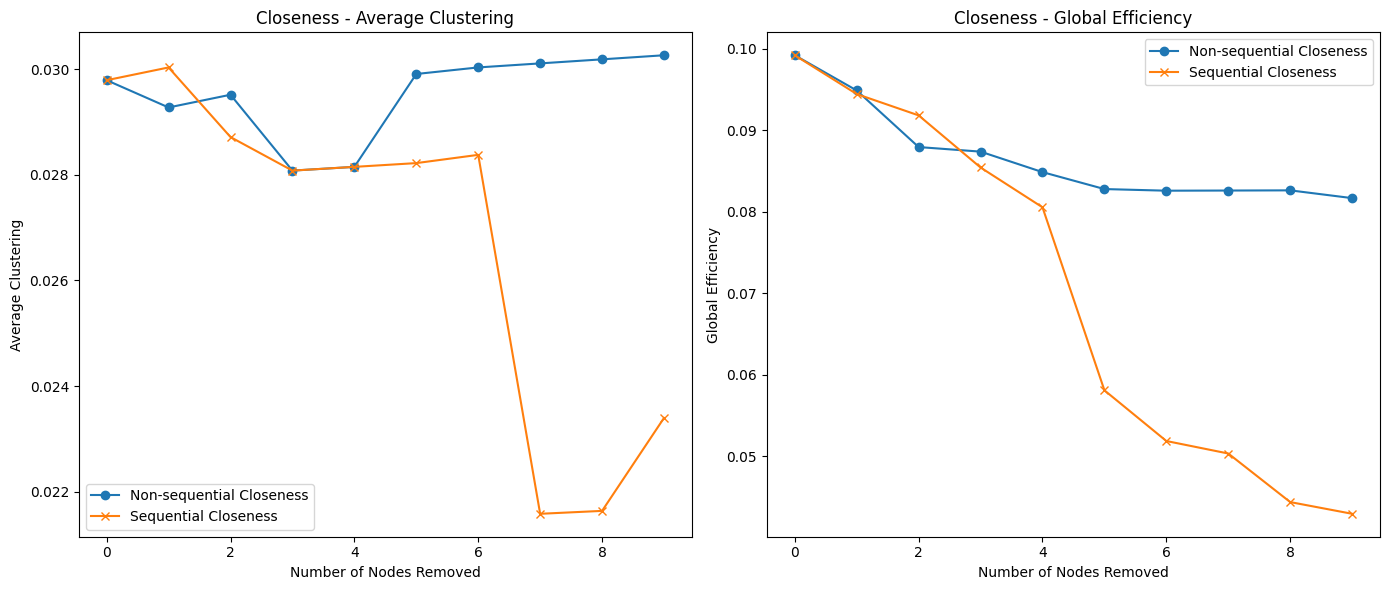

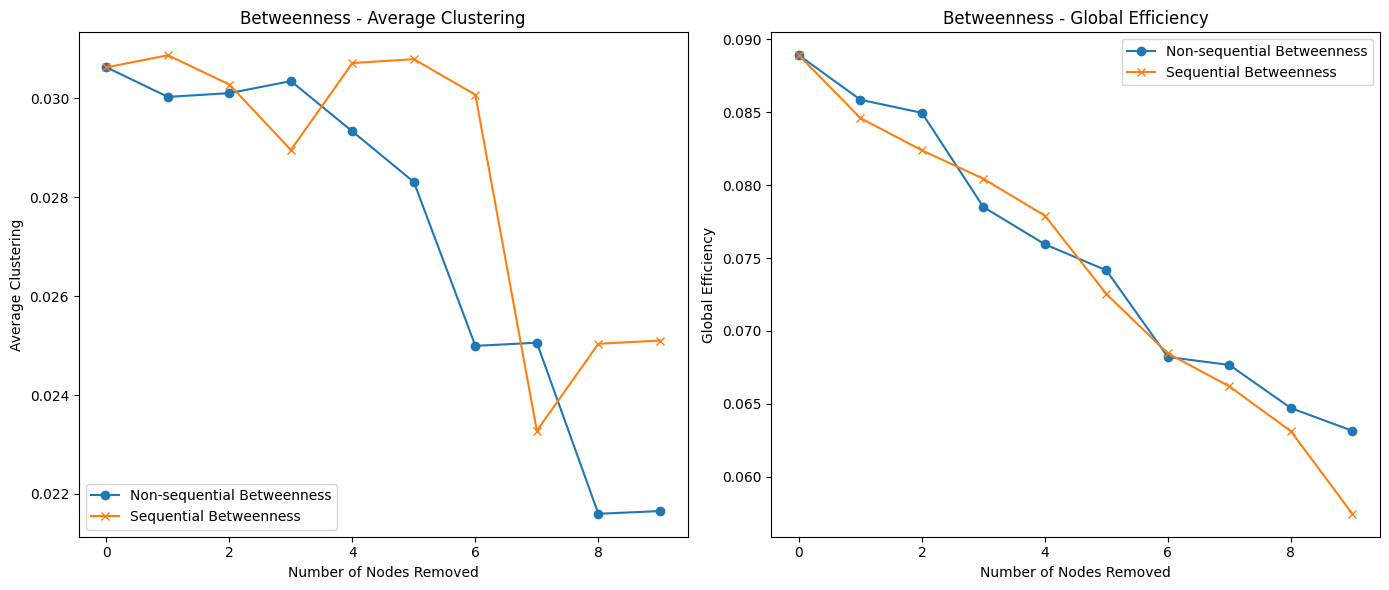

In [122]:
def compute_impact_measures(graph):
    try:
        global_efficiency = nx.global_efficiency(graph)
    except nx.NetworkXError:
        global_efficiency = float('inf')  # Inf if the graph is not connected
    return {
        "average_clustering": nx.average_clustering(graph),
        "global_efficiency": global_efficiency
    }

# Strategy A: Non-sequential Removal
def non_sequential_removal(G, top_nodes):
    impacts = []
    temp_graph = G.copy()
    for node in top_nodes.index:
        temp_graph.remove_node(node)
        impacts.append(compute_impact_measures(temp_graph))
    return impacts

# Strategy B: Sequential Removal
def sequential_removal(G, top_nodes):
    impacts = []
    temp_graph = G.copy()
    for _ in range(10):
        if temp_graph.number_of_nodes() == 0:
            break
        top_node = top_nodes.index[0]  # always remove the top node from the remaining graph
        temp_graph.remove_node(top_node)
        impacts.append(compute_impact_measures(temp_graph))
        # Recompute centrality and update top_nodes
        new_centrality = nx.degree_centrality(temp_graph) if "degree" in top_nodes.columns else \
                         nx.betweenness_centrality(temp_graph) if "betweenness" in top_nodes.columns else \
                         nx.closeness_centrality(temp_graph)
        new_df = pd.DataFrame(index=temp_graph.nodes())
        new_df[next(iter(new_centrality))] = pd.Series(new_centrality)
        top_nodes = new_df.sort_values(by=new_df.columns[0], ascending=False)
    return impacts

# Applying strategies to all three measures
results = {
    "Non-sequential Degree": non_sequential_removal(G, top_degree),
    "Sequential Degree": sequential_removal(G, top_degree),
    "Non-sequential Closeness": non_sequential_removal(G, top_closeness),
    "Sequential Closeness": sequential_removal(G, top_closeness),
    "Non-sequential Betweenness": non_sequential_removal(G, top_betweenness),
    "Sequential Betweenness": sequential_removal(G, top_betweenness)
}

centrality_measures = ['Degree', 'Closeness', 'Betweenness']
impact_measures = ['average_clustering', 'global_efficiency']

for measure in centrality_measures:
    plt.figure(figsize=(14, 6))
    
    for impact in impact_measures:
        non_sequential_impact = [result[impact] for result in results[f'Non-sequential {measure}']]
        sequential_impact = [result[impact] for result in results[f'Sequential {measure}']]
        
        plt.subplot(1, 2, 1 if impact == 'average_clustering' else 2)
        plt.plot(non_sequential_impact, label=f'Non-sequential {measure}', marker='o')
        plt.plot(sequential_impact, label=f'Sequential {measure}', marker='x')
        plt.title(f'{measure} - {impact.replace("_", " ").title()}')
        plt.xlabel('Number of Nodes Removed')
        plt.ylabel(impact.replace('_', ' ').title())
        plt.legend()
        plt.tight_layout()
    
    plt.show()

### Which centrality measure reflects better the importance of a station for the functioning of the underground?

Degree centrality: The graphs for degree centrality show a significant drop in both average clustering and global efficiency when nodes are removed both non-sequentially and sequentially. This suggests that nodes with high degree centrality are critical for maintaining the network's cohesion and efficiency,which indicating that it captures the impact better

Closeness centrality: 
 the global efficiency shows a steeper decline with sequential removal compared to non-sequential, which indicates the significance of these nodes in maintaining efficient communication paths across the network. The average clustering doesn’t change much with non-sequential removal but drops significantly with sequential removal, again highlighting the importance of strategically positioned nodes.

Betweenness centrality: The sequential removal of nodes with high betweenness centrality leads to a steep decline in global efficiency, and average clustering also drops but not significant,since there is some rise when drop 5th node with sequential removal. This suggests that nodes with high betweenness centrality are important for the flow of the network, acting as bridges or bottlenecks.

From these observations, degree centrality may reflect the importance of a station in the network most accurately because its removal has a significant impact on both the average clustering and global efficiency. It suggests these nodes are crucial for network connectivity and flow. However if we look into degree table, we can see some nodes with same degree centrality ,which may cause some subtle problem when we removing the nodes .

### Which strategy is more effective at studying resilience?
The strategy of sequential removal appears to be more effective at studying resilience. Sequential removal leads to a more pronounced impact on both the average clustering and global efficiency in the graphs. And sequential strategy recalculates the centrality measures after each removal of the most central node.It captures the dynamic evolution of the network's structure and performance as nodes are removed. It provides a method to simulate the continuous impact of real-world disruptions, such as the closure of transit stations, on the network.Moreover, Sequential removal considers the network's ability to reorganize itself when faced with disruptions, a process known as self-organization.

However Non-sequential removing nodes based on their centrality ranking at the initial state of the network,which does not adapt or change during the node removal process, so centrality measures are not recalculated, which  overlooks the dynamic nature of the network and may not accurately reflect gradual changes in network structure and function resulting from node removal.

### Which impact measure is better at assessing the damage after node removal?
Global efficiency seems to be a more sensitive measure of the damage after node removal.  It captures the impact on the network's connectivity and efficiency in a more pronounced and consistent manner across all three centrality measures. The steep and steady decline in global efficiency under sequential removal, especially, reflects how critical the removed nodes are for the overall communication in the network.

On the other hand, while average clustering does give insight into the potential for localized redundancy and resilience, its fluctuations suggest that it might be less consistent as a standalone measure of damage. The increase in average clustering after certain removals could indicate a reconfiguration where nodes become more tightly clustered, but this doesn't necessarily translate to effective network functioning, especially as global efficiency drops.

In summary:

Degree centrality better indicates the critical nodes for network functionality.

Sequential removal is a more effective strategy for studying resilience.

Global efficiency is a more robust impact measure for assessing damage after node removal

# II. Flows: weighted network


In [123]:
import networkx as nx
import pandas as pd


for u, v, d in G.edges(data=True):
    d['inv_flow'] = 1.0 / d['flows'] if d['flows'] else 0.0

# Then, recalculate the centralities with the inverted flow weights
degree_weighted = nx.degree_centrality(G)  # Degree centrality does not need weight
betweenness_weighted = nx.betweenness_centrality(G, weight='inv_flow', normalized=True)
closeness_weighted = nx.closeness_centrality(G, distance='inv_flow')

df_weighted = pd.DataFrame({
    'degree_weighted': pd.Series(degree_weighted),
    'closeness_weighted': pd.Series(closeness_weighted),
    'betweenness_weighted': pd.Series(betweenness_weighted)
})

# Now you can sort and find the top 10 nodes for each weighted centrality measure
top_degree_weighted = df_weighted.sort_values(by='degree_weighted', ascending=False).head(10)
top_closeness_weighted = df_weighted.sort_values(by='closeness_weighted', ascending=False).head(10)
top_betweenness_weighted = df_weighted.sort_values(by='betweenness_weighted', ascending=False).head(10)

top_degree_weighted  # This will display the top 10 nodes by degree centrality


,degree_weighted,closeness_weighted,betweenness_weighted
Stratford,0.0225,2322.699805,0.327381
Bank and Monument,0.0200,2364.577066,0.498227
King's Cross St. Pancras,0.0175,2287.452632,0.217390
Baker Street,0.0175,2318.242011,0.238643
Earl's Court,0.0150,2178.687665,0.195285
Oxford Circus,0.0150,2355.796242,0.265752
Liverpool Street,0.0150,2345.155626,0.332456
Waterloo,0.0150,2367.998823,0.399803
Green Park,0.0150,2377.569519,0.562563
Canning Town,0.0150,2205.452185,0.079185


In [124]:
top_closeness_weighted


,degree_weighted,closeness_weighted,betweenness_weighted
Green Park,0.0150,2377.569519,0.562563
Westminster,0.0100,2372.542016,0.371736
Waterloo,0.0150,2367.998823,0.399803
Bank and Monument,0.0200,2364.577066,0.498227
Oxford Circus,0.0150,2355.796242,0.265752
Bond Street,0.0100,2352.780789,0.288177
Victoria,0.0100,2345.842679,0.198625
Liverpool Street,0.0150,2345.155626,0.332456
Warren Street,0.0075,2329.989523,0.249574
Moorgate,0.0100,2325.095146,0.094539


In [125]:
top_betweenness_weighted

,degree_weighted,closeness_weighted,betweenness_weighted
Green Park,0.0150,2377.569519,0.562563
Bank and Monument,0.0200,2364.577066,0.498227
Waterloo,0.0150,2367.998823,0.399803
Westminster,0.0100,2372.542016,0.371736
Liverpool Street,0.0150,2345.155626,0.332456
Stratford,0.0225,2322.699805,0.327381
Bond Street,0.0100,2352.780789,0.288177
Euston,0.0125,2305.912940,0.279624
Oxford Circus,0.0150,2355.796242,0.265752
Warren Street,0.0075,2329.989523,0.249574


## II.1
In this part we add the flows data to the graph as weight on the edge. The more flow on the edge, the more important path is. We found different result comparing to the I.1
 Degree Centrality doesn't change in a weighted network because it simply counts the number of edges connected to a node. Whether the network is weighted or not doesn't impact this count; an edge is an edge, regardless of its weight. The degree centrality of a node is independent of the edge weights and is solely based on the number of connections that node has.However, both Betweenness and Closeness Centralitychanges because it measures the number of times a node acts as a bridge along the shortest path between two other nodes. When the network is weighted, the definition of "shortest" changes from being the path with the least number of edges to the path with the smallest sum of weights. Since we've redefined your edge weights to be the inverse of the flow, paths that were previously not considered (because they had too many edges) might now be recognized as 'shorter' (if they have higher passenger flows), changing the betweenness centrality of the nodes.

### II.2
In the weighted network. The impact of removal should take the weight into account. Weighted Clustering Coefficient shold  involves using the weights of the edges that form triangles in the network. The intention is to reflect the intensity or strength of these connections.Weighted Global Efficiency: This involves modifying the standard global efficiency formula to use the weighted shortest path lengths between nodes rather than unweighted paths. These weighted measures are thus more aligned with practical considerations in a transit network, making them more effective for planning and evaluating interventions like station closures, especially in scenarios where passenger convenience and efficiency are priorities.

In [126]:
import networkx as nx



# Calculate initial degree centrality
initial_degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality and pick the top 3
top_3_nodes = sorted(initial_degree_centrality, key=initial_degree_centrality.get, reverse=True)[:3]

# Function to calculate metrics
def calculate_metrics(graph):
    weighted_clustering = nx.average_clustering(graph, weight='weight')
    weighted_efficiency = nx.global_efficiency(nx.Graph(graph))
    return weighted_clustering, weighted_efficiency

# Initial metrics
initial_clustering, initial_efficiency = calculate_metrics(G)

# Impact of removing each of the top 3 nodes
results = {}
for node in top_3_nodes:
    # Remove node and create new graph
    G_temp = nx.Graph(G)
    G_temp.remove_node(node)
    
    # Calculate metrics for the new graph
    clustering, efficiency = calculate_metrics(G_temp)
    results[node] = {
        'Weighted Clustering Coefficient': clustering,
        'Weighted Global Efficiency': efficiency
    }

# Output results
for node, metrics in results.items():
    print(f"Removal of station {node}:")
    print(f"  Weighted Clustering Coefficient: {metrics['Weighted Clustering Coefficient']}")
    print(f"  Weighted Global Efficiency: {metrics['Weighted Global Efficiency']}")


Removal of station Stratford:
  Weighted Clustering Coefficient: 0.030625000000000003
  Weighted Global Efficiency: 0.08891736066510689
Removal of station Bank and Monument:
  Weighted Clustering Coefficient: 0.029869047619047625
  Weighted Global Efficiency: 0.09673475608480861
Removal of station Baker Street:
  Weighted Clustering Coefficient: 0.027422619047619053
  Weighted Global Efficiency: 0.09704487984670325


### II3

Lower Weighted Clustering Coefficient values indicate a greater reduction in local connectivity and tightness. Baker Street shows the lowest clustering coefficient, suggesting its removal disrupts local network structures the most significantly.

 Lower Weighted Global Efficiency values indicate a more significant decrease in the network’s ability to efficiently transport passengers across the entire system. Stratford shows the lowest global efficiency, indicating that its removal has the most substantial overall impact on the network's efficiency.

  Stratford's closure would likely have the largest impact on passengers, considering both the substantial decrease in global efficiency and the critical role it plays in maintaining broader network connectivity. This suggests that removing Stratford from the network would have the most severe overall impact on the network's ability to facilitate efficient passenger movement, making it potentially the most critical station in terms of supporting the network’s functionality.

# Part 2: Spatial Interaction models
## III. Models and calibration
### III 1
Spatial interaction models are used to predict and describe the flow (e.g., of people, goods, information) between different locations in space based on the characteristics of the origins, destinations, and the distance or impedance between them. These models are widely used in urban planning, geography, transportation, and related fields.
The gravity model is one of the most commonly used spatial interaction models. It is analogous to Newton's law of gravity and is based on the assumption that the interaction between two locations decreases with distance and increases with the mass (or size) of the locations. Gravity Model in spatial interaction modeling, specifically focusing on the unconstrained, singly constrained (either origin or destination), and doubly constrained models.

### A  unconstrained model

\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

Where $T_{ij}$ is the transition or flow i(rows in the matrix) is the origin and j destination(columns in the matrix)

$O$ is a vector represents as emissiveness of Origin, $D$ is attractiveness of destination.

- $k$, is the constant to adjust the scale ,

$\alpha$ measure the strength of produciton in the origin,

 $\gamma$ measure the strength of attractiveness in destinations 

 $β$ is  deterrence to adjust the scale of distance

 
$d$ is a matrix of costs relating to the flows between  i  and  j  - in our case the cost is the distance and it is called ‘dist’ in our dataset.

they are all the model parameters to be estimated

### Singly The Origin- Constrained Model (production-Constrained)

$$T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}$$
This model constrains the total outflows from each origin to equal a known total 
$O_{i}$ = $\sum_j T_{ij}$, ensuring the sum of flows from each origin matches actual observations.

$A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}$ is origin-specific balancing factor adjust outflows

 and rest of variables are the same as unconstrained one
 
 ### Singly Destination-Constrained Model (Attraction-Constrained)

  $$
T_{ij} = B_i O_i D_j^\gamma d_{ij}^{-\beta} \tag{1}
$$
conversely,  Destination-Constrained Model  is same as the Destination-Constrained  one. 

where:$B_j$ is destnation-specific balancing factor for adjust each destination  
$D_{i}$ = $\sum_i T_{ij}$ is the total flow into destination 
j, ensuring the model's predicted inflows align with actual measurements.

### Doubly Constrained Spatial Interaction Model
$$
T_{ij} = A_i O_i B_j D_j^\gamma d_{ij}^{-\beta} \tag{1}
$$

Where

\begin{equation} \tag{10}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{11}
D_j = \sum_i T_{ij} 
\end{equation}

and Balancing Factors

\begin{equation} \tag{12}
A_i = \frac{1}{\sum_j B_j D_j d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{13}
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}}
\end{equation}

### III2  Calibration of model


In this part,firstly, I assume that people residing at the origin are commuting to their workplaces at the destination. The population at the origin reflects its emission levels, while the number of jobs at the destination indicates its attractiveness to residents. Generally, people's places of residence tend to remain stable. I am going to use the Origin constrained mode to calibrate the parameter for the cost function.And model will use negative exponential cost function,  reason is as follow.

The model reflects a situation where the number of trips originating at each station (the origins) is known and fixed, which aligns with the stable residential population, while the job place can change.
 The negative exponential function is often preferred in urban studies where local interactions dominate (Chen, 2015).
 SoNegative exponential cost function might more accurately reflect the behavior of commuters than using the London Underground than Inverse power function, where distances might seem less daunting due to the network's efficiency and the typical urban commuting patterns. 
Origin constrained flow model below
$$T_{ij} = A_i O_i D_j^\gamma e^{-d_{ij}\beta}$$

and the regression model for calibrating is below 

$$\lambda_{ij} = \exp (\alpha_i + \gamma \ D_j - \beta \ d_{ij})$$




By the way, We can check the parameter for inverse power cost funciton where the regression model is 

$$\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})$$
Before we do the model, we need to do some process on the csv file.
We can seee that Battersea Park station has lots of 0 flow. It might because that this station is close. So to aviod the error during modeling, we need to remove this station Battersea Park

In [240]:
data=pd.read_csv('london_flows.csv')
data.rename(columns={'station_origin':'origin','station_destination':'destination'}, inplace=True)

x_variables = ["jobs", "distance"]
log_x_vars = []
for x in x_variables:
    data[f"log_{x}"] = np.log(data[x])
    log_x_vars.append(f"log_{x}")
    
#manipulation data
data = data[data.origin != 'Battersea Park']
data = data[data.destination != 'Battersea Park']


C:\Users\徐\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\徐\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [129]:
formula= 'flows ~ origin + log_jobs + distance -1'
prodSim = smf.glm(formula = formula, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61431
Model:                            GLM   Df Residuals:                    61031
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2195e+05
Date:                Sat, 20 Apr 2024   Deviance:                   1.6717e+06
Time:                        18:29:53   Pearson chi2:                 2.42e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
or

In [130]:
print(prodSim.params)

origin[Abbey Road]         -2.881019
origin[Acton Central]      -1.147701
origin[Acton Town]         -1.600210
origin[Aldgate]            -2.912647
origin[Aldgate East]       -2.824605
                              ...   
origin[Woodgrange Park]    -0.881059
origin[Woodside Park]      -1.145095
origin[Woolwich Arsenal]    0.535723
log_jobs                    0.750908
distance                   -0.000151
Length: 400, dtype: float64


In [131]:
formula2= 'flows ~ origin + log_jobs + log_distance -1'
prodSim2 = smf.glm(formula = formula, data=data, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim2.params)

origin[Abbey Road]         -2.881019
origin[Acton Central]      -1.147701
origin[Acton Town]         -1.600210
origin[Aldgate]            -2.912647
origin[Aldgate East]       -2.824605
                              ...   
origin[Woodgrange Park]    -0.881059
origin[Woodside Park]      -1.145095
origin[Woolwich Arsenal]    0.535723
log_jobs                    0.750908
distance                   -0.000151
Length: 400, dtype: float64


The result of regression model is shown below. $\alpha_i$ is a vector  The calibrated parameter indicating the intercept factor on the flow for the each origin station, capture the feature from origin to other destinations.

 $\beta$  is 0.000151 very small in for both cost function which means that when travel distance increase, flow decrease slightly
  
  ,and the coeffcient $\gamma$ for destination is 0.7509 indicating that x additional job at destination j will lead to $x^{j}$ increase. 

## IV. Scenarios
### IV.1
Since Canary Wharf has a 50% decrease in jobs after Brexit， and other data still the same, we need to rebuild the new balancing factor of Origin $A_{i}$ and new $D_j^\gamma$ to construct new flow funciton. 
Where $$A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}$$

Firstly, caculate the $D_j^\gamma$ with new jobs, and build new $A_{i}$ with new   $D_j^\gamma$. Then Using the
calibrated parameter $\beta$, estimate the new flows for scenario A. Where
 $$T_{ij} = A_i O_i D_j^\gamma e^{-\beta d_{ij}}$$ 

In [207]:
# Create a new column 'Jobs_ScenarioA' initialized with the 'jobs' column
data['Jobs_ScenarioA'] = data['jobs']

# Apply the condition to modify 'Jobs_ScenarioA' where 'destination' equals 'Canary Wharf'
data.loc[data['destination'] == 'Canary Wharf', 'Jobs_ScenarioA'] *= 0.5
alpha_i = prodSim.params[:-2]
gamma = prodSim.params[-2]
beta = - prodSim.params[-1]
dist_beta = np.exp(data['distance']*-beta) 
Dj_gamma= data['Jobs_ScenarioA']**gamma

data["Ai1"] = Dj_gamma * dist_beta
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
data = data.merge(A_i, left_on="origin", right_index=True, how="left")


C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1795326940.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodSim.params[-2]
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1795326940.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = - prodSim.params[-1]
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1795326940.py:13: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(data.groupby(["origin"

In [208]:
#generate the flow
data["prodsimest"] = data["A_i2"]*data["population"]*Dj_gamma*dist_beta
#round
data["prodsimest"] = round(data["prodsimest"])

In [209]:
#show the diff
datamat_after = data.pivot_table(values ="prodsimest", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat_before = pd.pivot_table(data, values='flows', index=['origin'], columns=['destination'],
                         aggfunc=np.sum, margins=True)
datamat_before

C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1156537132.py:2: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_after = data.pivot_table(values ="prodsimest", index="origin", columns = "destination",
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1156537132.py:2: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_after = data.pivot_table(values ="prodsimest", index="origin", columns = "destination",
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1156537132.py:2: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a f

C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1156537132.py:4: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_before = pd.pivot_table(data, values='flows', index=['origin'], columns=['destination'],


destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [136]:
datamat_after

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,602.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,14.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3746.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2880.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4858.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,20.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


we can see there is only subtle diffference between initial total commuters number:1542391 and adjusted model commuters number: 1541507. Number of commuters  number drops 884 in the whole London underground system.

## IV.2. Scenario B
In Scenario B $D_j^\gamma$ still the same, since the job not changes.
And it assumes that there is a significant increase in the cost of transport. When the transportation cost increases, the beta value is expected to increase, which reflects the greater impact of the increased distance cost on the traffic flow. This change causes the traffic predicted by the model to decay faster with distance, suggesting that the increase in cost makes the cost of traveling long distances more significant. Which will increase the paremeter of cost function $\beta$. And It will lead to a guess that presumably, people would prefer to commute closer to where they live.  In the previous model we get the $\beta$ equals to 0.000151. So I am going to select 0.0004 and 0.0004 in Scenario B. And I will continue the origina-constrained model. 
Firstly, I need to calculate new $A_i$ for the new beta for create new flow distribution 

In [243]:
#get new Ai for beta1
beta1=-0.0003


dist_beta1 = np.exp(data['distance']*beta1) 
Dj_gamma_sB= data['jobs']**gamma

data["Ai1"] = Dj_gamma_sB * dist_beta1
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i4"}, inplace=True)
data = data.merge(A_i, left_on="origin", right_index=True, how="left")


C:\Users\徐\AppData\Local\Temp\ipykernel_14636\466508132.py:9: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))


In [244]:
data["sBsimest"] = data["A_i4"]*data["population"]*Dj_gamma_sB*dist_beta1

data["sBsimest"] = round(data["sBsimest"])

datamat_B1 = data.pivot_table(values ="sBsimest", index="origin", columns = "destination",
                            aggfunc=np.sum, margins=True)
datamat_B1

C:\Users\徐\AppData\Local\Temp\ipykernel_14636\3003050841.py:5: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_B1 = data.pivot_table(values ="sBsimest", index="origin", columns = "destination",
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\3003050841.py:5: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_B1 = data.pivot_table(values ="sBsimest", index="origin", columns = "destination",
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\3003050841.py:5: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future vers

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,4.0,4.0,NaN,26.0,0.0,NaN,6.0,...,5.0,1.0,0.0,30.0,NaN,0.0,NaN,0.0,NaN,3739.0
Aldgate,NaN,NaN,0.0,NaN,55.0,NaN,NaN,0.0,NaN,30.0,...,0.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2880.0
Aldgate East,NaN,NaN,0.0,60.0,NaN,NaN,0.0,0.0,NaN,31.0,...,0.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,27.0,41.0,NaN,NaN,NaN,NaN,14.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,0.0,11.0,10.0,NaN,0.0,NaN,NaN,28.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3084.0


In [241]:
# get the flow for beta2

beta2=-0.001
dist_beta2 = np.exp(data['distance']*beta2) 
Dj_gamma_sB2= data['jobs']**gamma

data["Ai1"] = Dj_gamma_sB2 * dist_beta2
A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i5"}, inplace=True)
data = data.merge(A_i, left_on="origin", right_index=True, how="left")


C:\Users\徐\AppData\Local\Temp\ipykernel_14636\1106287735.py:8: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(data.groupby(["origin"])["Ai1"].agg(np.sum))


In [242]:
data["sBsimest2"] = data["A_i5"]*data["population"]*Dj_gamma_sB*dist_beta2

data["sBsimest2"] = round(data["sBsimest2"])

datamat_B2 = data.pivot_table(values ="sBsimest2", index="origin", columns = "destination", aggfunc=np.sum, margins=True)
datamat_B2

C:\Users\徐\AppData\Local\Temp\ipykernel_14636\134834882.py:5: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_B2 = data.pivot_table(values ="sBsimest2", index="origin", columns = "destination", aggfunc=np.sum, margins=True)
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\134834882.py:5: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  datamat_B2 = data.pivot_table(values ="sBsimest2", index="origin", columns = "destination", aggfunc=np.sum, margins=True)
C:\Users\徐\AppData\Local\Temp\ipykernel_14636\134834882.py:5: FutureWarning: The provided callable <function sum at 0x000001C9BDCFD3A0

destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,12.0,0.0,NaN,0.0,...,0.0,0.0,0.0,5.0,NaN,0.0,NaN,0.0,NaN,3745.0
Aldgate,NaN,NaN,0.0,NaN,95.0,NaN,NaN,0.0,NaN,12.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2886.0
Aldgate East,NaN,NaN,0.0,115.0,NaN,NaN,0.0,0.0,NaN,11.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3171.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4864.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In the both scenarios, the total flow number is almost same as the initial model.The number of all commuters only drop slightly less than 1500 in both $\beta$ value. It might indicate that London underground has a very strong resillence. People willl not disappear in this model, it is likely that people prefer to work at a place which is close to their residence.

## IV.3
### Scenario A:
With a reduction in jobs at Canary Wharf  Canary Wharf will decrease as the attractiveness of the destination decreases. This will likely result in a redistribution of flows towards other destinations with unchanged job numbers, as commuters might seek employment in areas that have not experienced such drastic job reductions.
A decrease of 884 in total commuter numbers could be interpreted as some commuters possibly dropping out of the workforce or shifting to remote work, reflecting a significant but localized impact.

However adjusted model flows into Canary Wharf was droped from 58772.0 to 30075.0 represents a decrease of approximately 48.8%, which closely aligns with the 50% job reduction at Canary Wharf. This observation indicates that the model's predictions are reasonably consistent with the theoretical expectations from the gravity model thay the  attractiveness can affect flow.

### Scenario B
 A higher β value increases the cost or deterrence effect in the gravity model, making distance a more substantial barrier to commuting. Commuters are more likely to choose jobs closer to home, reducing longer-distance commuting and potentially increasing local traffic.  A decrease of 1400 in total commuter numbers is indicative of a more substantial impact across the network, not just localized. This suggests that many commuters have either stopped commuting or significantly altered their commuting patterns to much shorter routes.

 ### Conclusion

 Scenario B would generally have a more significant impact on the redistribution of flows compared to Scenario A. The increased transportation costs in Scenario B affect all commuters, leading to a reevaluation of commuting decisions across the board, which could lead to more dramatic shifts in urban mobility patterns than the job reductions in a single location as seen in Scenario A.

In [252]:
print(datamat_before['Canary Wharf'])

origin
Abbey Road              1.0
Acton Central           NaN
Acton Town             57.0
Aldgate                 1.0
Aldgate East            3.0
                     ...   
Woodford              192.0
Woodgrange Park         NaN
Woodside Park          42.0
Woolwich Arsenal       82.0
All                 58772.0
Name: Canary Wharf, Length: 399, dtype: float64


In [251]:
print(datamat_after['Canary Wharf'])

origin
Abbey Road             63.0
Acton Central           NaN
Acton Town             21.0
Aldgate                46.0
Aldgate East           63.0
                     ...   
Woodford              150.0
Woodgrange Park         NaN
Woodside Park          25.0
Woolwich Arsenal      946.0
All                 30075.0
Name: Canary Wharf, Length: 399, dtype: float64


In [246]:
import json

def calculate_markdown_word_count(ipynb_file_path):
    with open(ipynb_file_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    
    word_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            text = ''.join(cell['source'])
            word_count += len(text.split())
    
    return word_count

file_path = r'.\cw.ipynb'


print(f"Total word count in Markdown cells: {calculate_markdown_word_count(file_path)}")

Total word count in Markdown cells: 3107
